### Need to first run `simulate_full.ipynb` to generate the data used in this notbeook

In [1]:
import numpy as np
import joblib
import skimage
import matplotlib as mpl

import matplotlib.pyplot as plt
import scipy
import tifffile as tif
from tqdm.notebook import tqdm
from pathlib import Path
from cycler import cycler
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [2]:
def recons_scipy(orig_recons_this, mask_this, kernel='thin_plate_spline', **kwargs):
    
    mask_bool = mask_this.astype('bool')
    measured_idxs_this = np.array(np.where(mask_bool)).T
    unmeasured_idxs_this = np.array(np.where(~mask_bool)).T
    values_this = orig_recons_this[mask_bool]
    
    interp = scipy.interpolate.RBFInterpolator(measured_idxs_this,
                                         values_this, 
                                         kernel=kernel,
                                         neighbors=10, smoothing=0.01, epsilon=0.1, **kwargs)
    ynew = interp(unmeasured_idxs_this)
    #ynew = np.clip(ynew, a_max=np.inf, a_min=0)
    #ynew = ynew / ynew.max() * 100
    
    out = orig_recons_this.copy()
    out[~mask_bool] = ynew
    return out.astype('float32')

In [3]:
ffilt = lambda x: skimage.filters.median(x)
fdscale = lambda x: skimage.transform.rescale(x, 0.5, preserve_range=True)
fssim = lambda x, y: skimage.metrics.structural_similarity(x, y)
fmse = lambda x, y: skimage.metrics.normalized_root_mse(x, y)
frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype('bool'))


In [4]:
def get_metrics(masks, recons):
    recons_bh = []
    mses = []
    ssims = []
    ssim_downs = []
    mse_downs = []
    ratios = []
    
    rmin = recons[-1].min()
    rmax = recons[-1].max()
    scaling = (ground.max() - ground.min()) / (rmax - rmin)
    inputs = list(zip(masks, recons))
    for m, r in tqdm(inputs):
        #    r = r[::-1,::-1][2:-2, 9:-6]
        #    m = m[::-1, ::-1][2:-2, 9:-6]
        #    r = r * fast_normalizer
        r = (r - rmin) * scaling + ground.min()
        r_bh = frbh(r, m)
        
        
        #r_bh = recons_scipy(r, m, kernel='thin_plate_spline')
        #if not fast:
        #    r = skimage.transform.resize(r, ground.shape, preserve_range=True)
        #    r_bh = skimage.transform.resize(r, ground.shape, preserve_range=True)
        recons_bh.append(r_bh)
        ms1 = fmse(ground, r)
        ms2 = fmse(ground, r_bh)

        mses.append((ms1, ms2))

        sm1 = fssim(ground, r)
        sm2 = fssim(ground, r_bh)

        ssims.append((sm1, sm2))
        
    return np.array(recons_bh), np.array(mses), np.array(ssims)

In [6]:
fig_path = Path('figures/')
if not fig_path.exists():
    fig_path.mkdir()

In [7]:
data_all = joblib.load('full_sims_fast_random_raster.pkl')
data_all = {k:np.array(v) for k,v in data_all.items()}

In [8]:
ground = tif.imread('fused_full.tif')
print(ground.max())
ground = ground / ground.max()

299339.0


In [9]:
indices = np.arange(len(data_all['ratios']) - 1, 0, -2)[::-1]
data_all['ratios'][indices]

array([0.03083333, 0.05166667, 0.0725    , 0.09333333])

In [10]:
indices.size

4

In [13]:
reload_data = False

In [14]:
if not reload_data:
    full_outs_fast = get_metrics(data_all['fast_masks'][indices], data_all['fast_recons'][indices])
    joblib.dump(full_outs_fast, 'analysis_full_outs_fast.pkl', compress=3, protocol=-1)
else:
    full_outs_fast = joblib.load('analysis_full_outs_fast.pkl')


[
    fast_recons_bh, 
    fast_mses, fast_ssims
] = full_outs_fast

  0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
if not reload_data:
    full_outs_lr = get_metrics(data_all['smart_random_masks'][indices], data_all['smart_random_recons'][indices])
    joblib.dump(full_outs_lr, 'analysis_full_outs_lr.pkl', compress=3, protocol=-1)
else:
    full_outs_lr = joblib.load('analysis_full_outs_lr.pkl')

[
    lr_recons_bh, 
    lr_mses, lr_ssims
]= full_outs_lr



  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
if not reload_data:
    full_outs_ur = get_metrics(data_all['unif_random_masks'][indices], data_all['unif_random_recons'][indices])
    joblib.dump(full_outs_ur, 'analysis_full_outs_ur.pkl', compress=3, protocol=-1)
else:
    full_outs_ur = joblib.load('analysis_full_outs_ur.pkl')

[
    ur_recons_bh, 
    ur_mses, ur_ssims
]= full_outs_ur



  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
if not reload_data:
    full_outs_r = get_metrics(data_all['raster_masks'][indices[:-1]], data_all['raster_recons'][indices[:-1]])
    joblib.dump(full_outs_r, 'analysis_full_outs_raster.pkl', compress=3, protocol=-1)
else:
    full_outs_r = joblib.load('analysis_full_outs_raster.pkl')

[
    r_recons_bh, 
    r_mses, r_ssims
]= full_outs_r



  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
data_all.keys()

dict_keys(['ratios', 'fast_recons', 'fast_masks', 'smart_random_recons', 'smart_random_masks', 'unif_random_recons', 'unif_random_masks', 'raster_recons', 'raster_masks'])

In [22]:
ratios = data_all['ratios'][indices]
percentages = ratios * 100

In [23]:
custom_cycler = (cycler(color=['r', 'g', 'b', 'm']) +
                cycler(linestyle=['-', '--', ':', '-.']) +
                cycler(marker=['o','*', 'D', 'P']))

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_44778/2891951678.py:35: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.089)


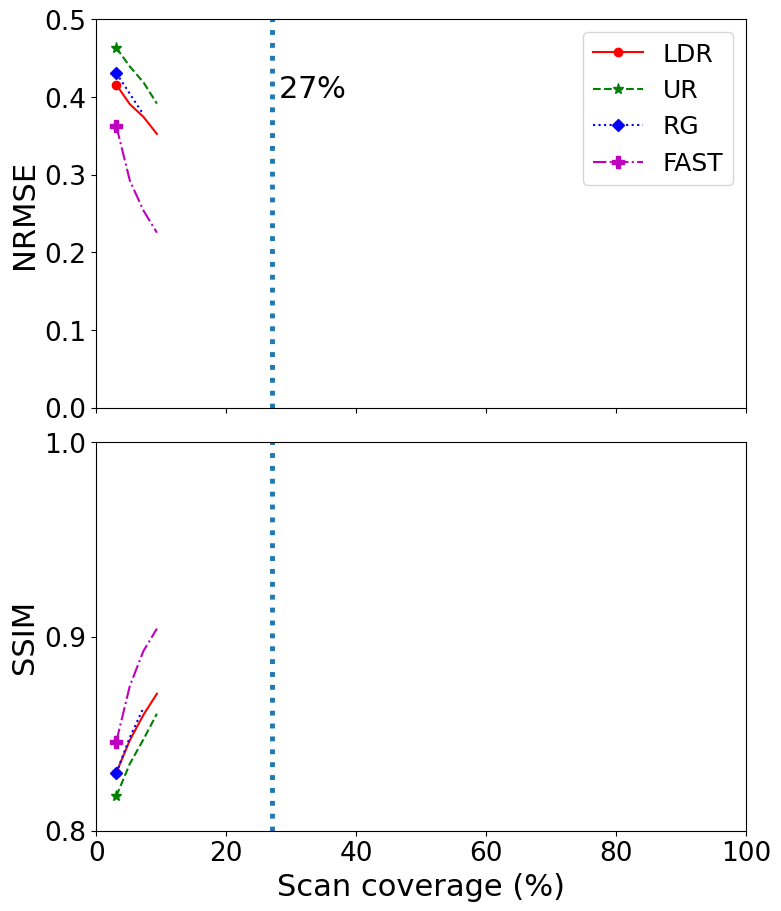

In [24]:
fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, figsize=[7.7, 9])


axs[0].set_prop_cycle(custom_cycler)
axs[0].plot(percentages, lr_mses[:,1], label='LDR', markevery=0.2, markersize=6)
axs[0].plot(percentages, ur_mses[:,1], label='UR', markevery=0.2, markersize=8)
axs[0].plot(percentages[:-1], r_mses[:,1], label='RG', markevery=0.2, markersize=6)
axs[0].plot(percentages, fast_mses[:,1], label='FAST', markevery=0.2, markersize=8)
axs[0].set_ylim(0.0, 0.5)
axs[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axs[0].tick_params(labelsize=19)
axs[0].set_ylabel(r"NRMSE", fontsize=22)
axs[0].legend(loc='upper right', fontsize=18)
axs[0].vlines([27], ymin=0,ymax=0.5, ls=':', linewidth=3.5)
axs[0].text(28, 0.4, r'$27\%$', size=22)
#axs[0].set_xlabel('Scan coverage (%)', fontsize=22)
#plt.savefig(fig_path/'mse.svg', transparent=True, bbox_inches='tight')

axs[1].set_prop_cycle(custom_cycler)
axs[1].plot(percentages, lr_ssims[:,0], label='LDR', markevery=0.2, markersize=6)
axs[1].plot(percentages, ur_ssims[:,1], label='UR', markevery=0.2, markersize=8)
axs[1].plot(percentages[:-1], r_ssims[:,1], label='RG', markevery=0.2, markersize=6)
axs[1].plot(percentages, fast_ssims[:,1], label='FAST', markevery=0.2, markersize=8)
#axs[1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axs[1].set_ylim([0.8, 1.0])
axs[1].set_yticks([0.8, 0.9, 1.0])
axs[1].tick_params(labelsize=19)
axs[1].set_ylabel(r"SSIM", fontsize=22)
axs[1].set_xlabel('Scan coverage (%)', fontsize=22)
axs[1].set_xlim(0, 100)

axs[1].vlines([27], ymin=0.8, ymax=1.0, ls=':', linewidth=3.5)
#axs[1].legend(loc=(0.01,0.85), fontsize=17)

plt.subplots_adjust(hspace=0.089)

plt.savefig(fig_path/'mse_ssim.svg', transparent=True, bbox_inches='tight')
plt.show()


In [25]:
testrs = np.array([0.05, 0.1, 0.2, 0.3])
rnums = []
for r in testrs:
    rnum = np.argmin(np.abs(ratios - r))
    print(rnum, ratios[rnum])
    rnums.append(rnum)

1 0.051666666666666666
3 0.09333333333333334
3 0.09333333333333334
3 0.09333333333333334


Ratios[23] gives scan percentage 20.

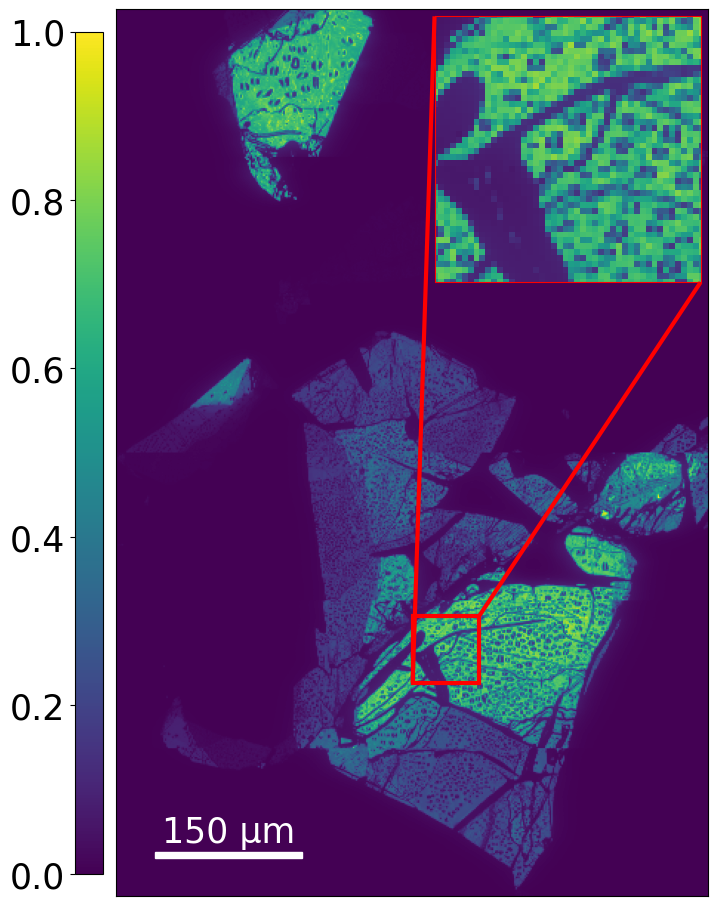

In [26]:
plt.figure(figsize=[7.5, 9], constrained_layout=True)
ax = plt.gca()
#plt.gca().set_rasterization_zorder(1)
plt.imshow(ground, vmin=0, vmax=ground.max(), rasterized=True)#, zorder=0)
#plt.title(f'{label} ({percent}%)', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.clim(0, ground.max())
cbar = plt.colorbar(pad=0.01, shrink=0.95, aspect=30, location='left')

scalebar = AnchoredSizeBar(plt.gca().transData,
                           100, u'150 μm', 'lower left', 
                           pad=1, label_top = True,
                           color='white',
                           frameon=False,
                           size_vertical=4, fontproperties = {'size':25})

ax.add_artist(scalebar)
cbar.ax.tick_params(labelsize=25)



inset_axes = zoomed_inset_axes(ax,
                               4, 
                               loc=1)
for spine in inset_axes.spines.values():
    spine.set_edgecolor('red')

inset_axes.imshow(ground, vmin=0, vmax=1, rasterized=True)
inset_axes.set_xlim([200, 245])
inset_axes.set_ylim([410, 455])
inset_axes.set(xticks=[], yticks=[])
inset_axes.invert_yaxis()
#x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
#axins2.set_xlim(x1, x2)
#axins2.set_ylim(y1, y2)
# fix the number of ticks on the inset axes
#axins2.yaxis.get_major_locator().set_params(nbins=7)
#axins2.xaxis.get_major_locator().set_params(nbins=7)
#axins2.tick_params(labelleft=False, labelbottom=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, inset_axes, loc1=2, loc2=4, fc="none", ec="red", linewidth=3.0)


plt.savefig(fig_path / 'ground.svg', bbox_inches='tight', transparent=True, dpi=600)
#plt.draw()
plt.show()

In [27]:
data_all.keys()

dict_keys(['ratios', 'fast_recons', 'fast_masks', 'smart_random_recons', 'smart_random_masks', 'unif_random_recons', 'unif_random_masks', 'raster_recons', 'raster_masks'])

In [28]:
rnums

[1, 3, 3, 3]

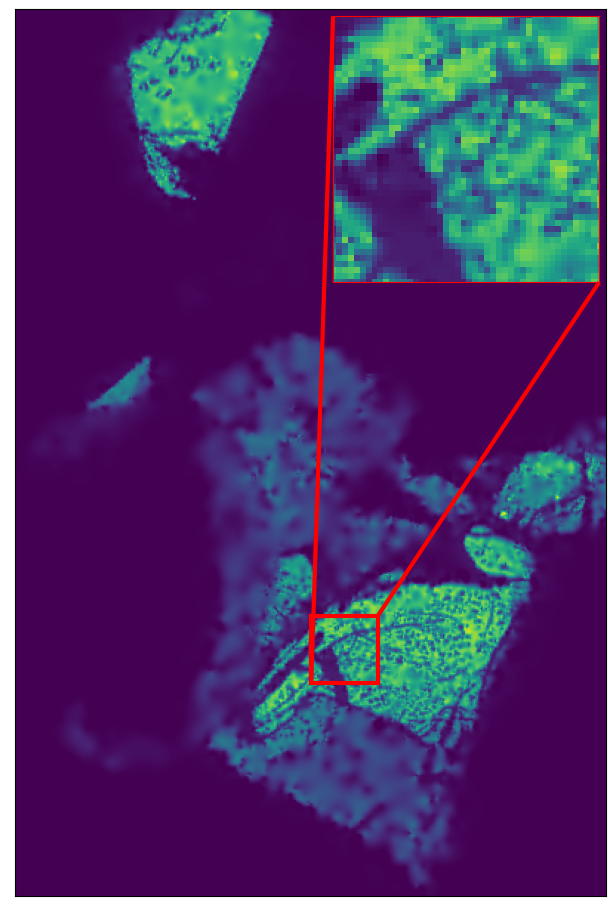

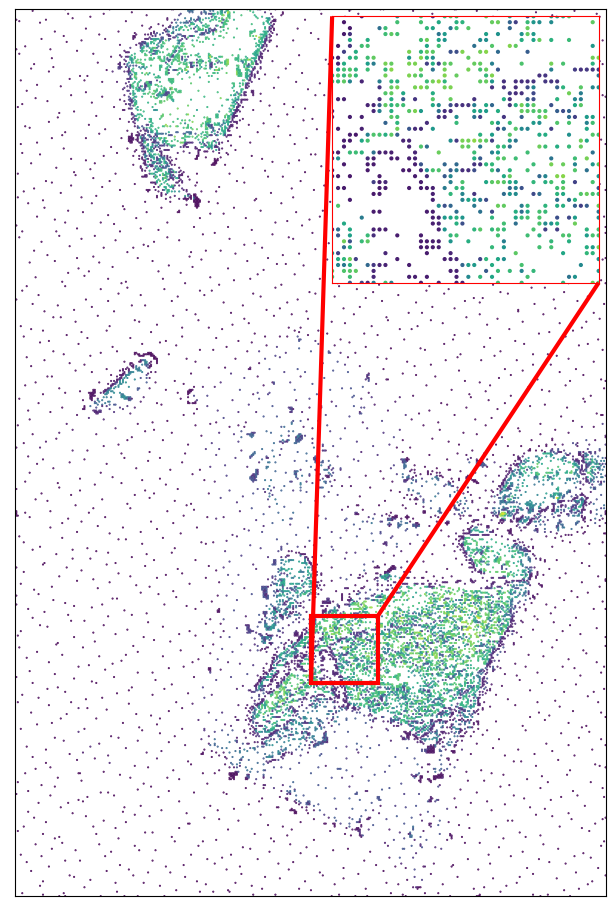

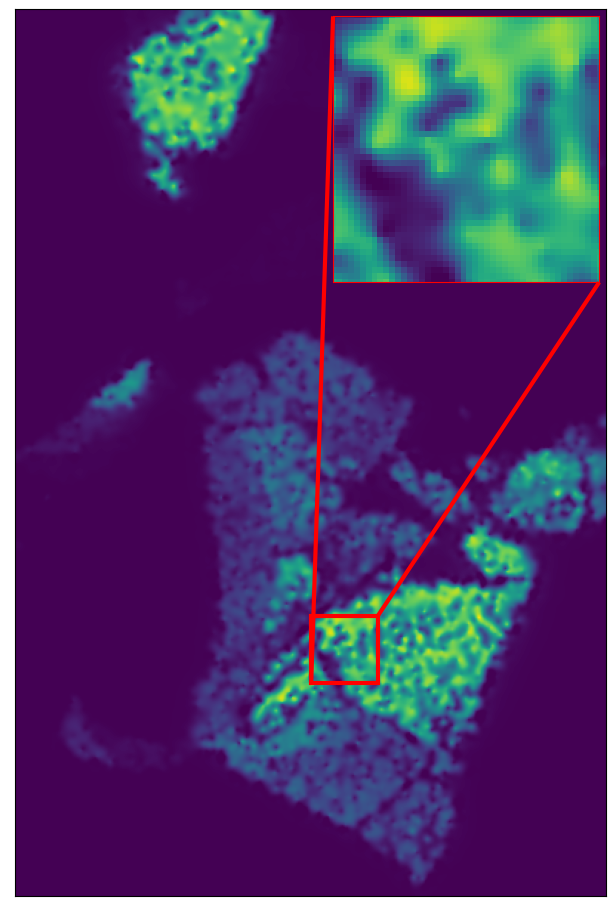

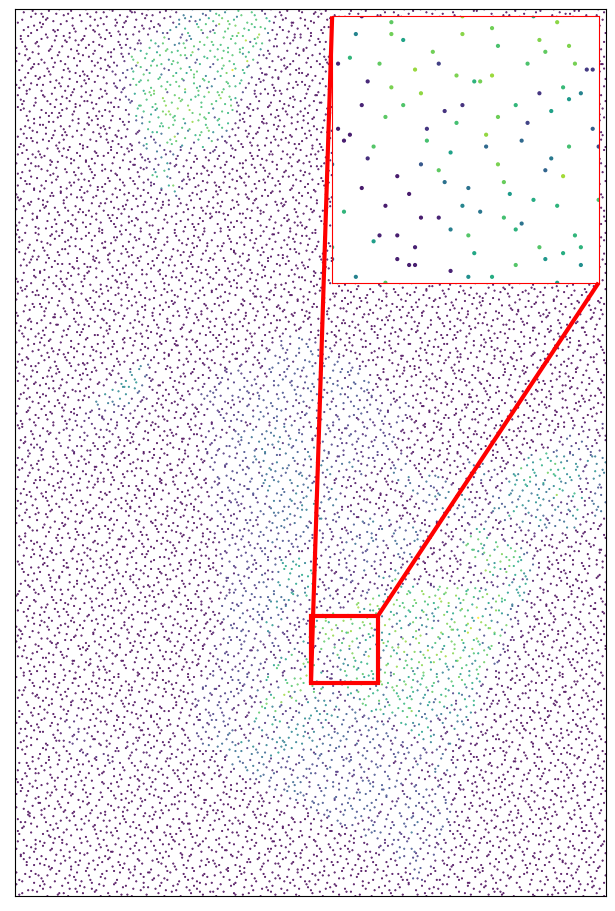

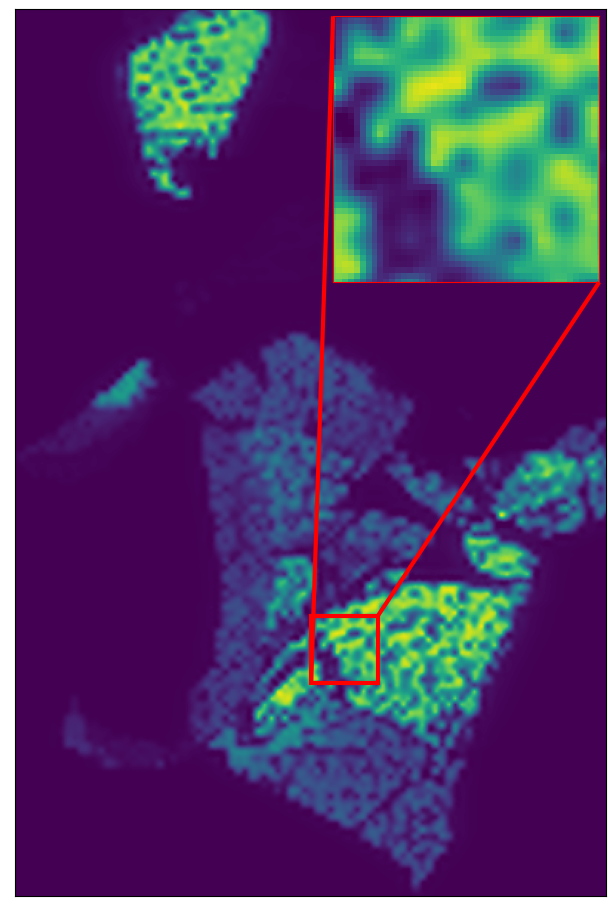

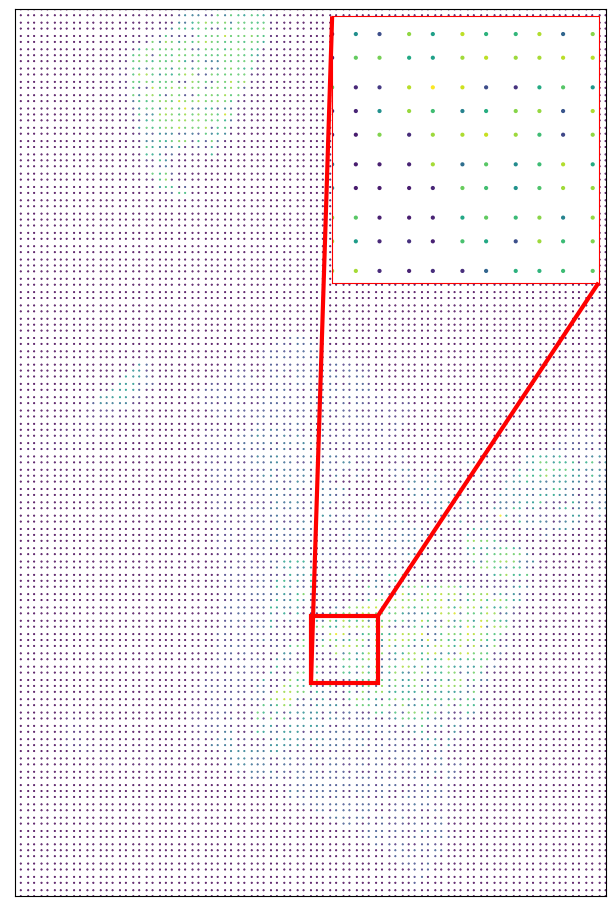

IndexError: index 3 is out of bounds for axis 0 with size 3

In [30]:
for rnum in rnums:
    labels = {'fast': (fast_recons_bh[rnum], data_all['fast_masks'][indices][rnum]),
              'random': (lr_recons_bh[rnum], data_all['smart_random_masks'][indices][rnum]),
              'raster': (r_recons_bh[rnum], data_all['raster_masks'][indices[:-1]][rnum])}
    percent = np.round(ratios[rnum] * 100).astype('int')

    for label, (arr, m) in labels.items():
        #m = m[::-1,::-1]
        plt.figure(figsize=[7.5, 9], constrained_layout=True)
        ax = plt.gca()
        plt.imshow(arr, vmin=0, vmax=ground.max(), rasterized=True)#, zorder=0)
        #plt.title(f'{label} ({percent}%)', fontsize=16)
        #plt.text(6, 20, f'{percent}%', fontsize=25, c='red')
        plt.xticks([])
        plt.yticks([])
        plt.clim(0, ground.max())
        #cbar = plt.colorbar(pad=0.01, shrink=0.9, aspect=50)

        #cbar.ax.tick_params(labelsize=25) 
        inset_axes = zoomed_inset_axes(ax,
                               4, 
                               loc=1)
        for spine in inset_axes.spines.values():
            spine.set_edgecolor('red')

        inset_axes.imshow(arr, vmin=0, vmax=1, rasterized=True)
        inset_axes.set_xlim([200, 245])
        inset_axes.set_ylim([410, 455])
        inset_axes.set(xticks=[], yticks=[])
        inset_axes.invert_yaxis()

        mark_inset(ax, inset_axes, loc1=2, loc2=4, fc="none", ec="red", linewidth=3.0)
        
        plt.savefig(fig_path / f'{label}_{percent}_interp.svg', bbox_inches='tight', transparent=True, dpi=600)
        plt.show()


        m_this = m
        #if label =='fast':
        #    m_this = m[::-1,::-1]
        
        ypoints, xpoints = np.where(m_this)
        ints = arr[ypoints, xpoints]

        plt.figure(figsize=[7.5, 9], constrained_layout=True)
        plt.scatter(xpoints, ypoints, c=ints,  
                    cmap='viridis', s=0.25, rasterized=True,
                    zorder=0)
        
        ax = plt.gca()
        ax.set_aspect('equal')
        #plt.text(6, 20, f'{percent}%', fontsize=25, c='red')
        #plt.title(f'{label} ({percent}%)', fontsize=16)
        plt.xticks([])
        plt.yticks([])
        plt.xlim(0,399)
        plt.ylim(0, 599)
        #plt.gca().invert_yaxis()
        ax.invert_yaxis()
        plt.clim(0, ground.max())
        
        
        inset_axes = zoomed_inset_axes(ax,
                               4, 
                               loc=1)
        for spine in inset_axes.spines.values():
            spine.set_edgecolor('red')

        inset_axes.scatter(xpoints, ypoints, c=ints, cmap='viridis', s=4, rasterized=True, facecolor='white',
                          zorder=1)
        
        inset_axes.set_xlim([200, 245])
        inset_axes.set_ylim([410, 455])
        inset_axes.set(xticks=[], yticks=[])
        inset_axes.invert_yaxis()
        inset_axes.patch.set_alpha(1.0)

        mark_inset(ax, inset_axes, loc1=2, loc2=4, fc="none", ec="red", linewidth=3.0)
        
        #cbar = plt.colorbar(pad=0.01, shrink=0.9, aspect=50)

        #cbar.ax.tick_params(labelsize=25) 
        plt.savefig(fig_path / f'{label}_{percent}_scatter.svg', bbox_inches='tight', transparent=False, dpi=600)
        plt.show()

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=[20,5], constrained_layout=True)


rnum = 2

plt.subplot(1,5,1)
plt.imshow(ground, interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
#plt.imshow(ground_transf2, vmin=0, vmax=255, aspect=40/38/200*199)
plt.colorbar(pad=0.01, shrink=0.9)
plt.title('ground')

plt.subplot(1,5,2)
plt.imshow(fast_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'fast {ratios[rnum]:3.2f}')

plt.subplot(1,5,3)
plt.imshow(lr_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'smart random {ratios[rnum]:3.2f}')

plt.subplot(1,5,4)
plt.imshow(ur_recons_bh[rnum],  interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'unif random {ratios[rnum]:3.2f}')

plt.subplot(1,5,5)
plt.imshow(r_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'raster {ratios[rnum]:3.2f}')

#plt.savefig('ground_129_transformed_final.png', bbox_inches='tight')transparent

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=[20,5], constrained_layout=True)


rnum = 5

plt.subplot(1,5,1)
plt.imshow(ground, interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
#plt.imshow(ground_transf2, vmin=0, vmax=255, aspect=40/38/200*199)
plt.colorbar(pad=0.01, shrink=0.9)
plt.title('ground')

plt.subplot(1,5,2)
plt.imshow(fast_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'fast {ratios[rnum]:3.2f}')

plt.subplot(1,5,3)
plt.imshow(lr_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'smart random {ratios[rnum]:3.2f}')

plt.subplot(1,5,4)
plt.imshow(ur_recons_bh[rnum],  interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'unif random {ratios[rnum]:3.2f}')

plt.subplot(1,5,5)
plt.imshow(r_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'raster {ratios[rnum]:3.2f}')

#plt.savefig('ground_129_transformed_final.png', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=[20,5], constrained_layout=True)


rnum = 8

plt.subplot(1,5,1)
plt.imshow(ground, interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
#plt.imshow(ground_transf2, vmin=0, vmax=255, aspect=40/38/200*199)
plt.colorbar(pad=0.01, shrink=0.9)
plt.title('ground')

plt.subplot(1,5,2)
plt.imshow(fast_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'fast {ratios[rnum]:3.2f}')

plt.subplot(1,5,3)
plt.imshow(lr_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'smart random {ratios[rnum]:3.2f}')

plt.subplot(1,5,4)
plt.imshow(ur_recons_bh[rnum],  interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'unif random {ratios[rnum]:3.2f}')

plt.subplot(1,5,5)
plt.imshow(r_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'raster {ratios[rnum]:3.2f}')

#plt.savefig('ground_129_transformed_final.png', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=[20,5], constrained_layout=True)


rnum = 11

plt.subplot(1,5,1)
plt.imshow(ground, interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
#plt.imshow(ground_transf2, vmin=0, vmax=255, aspect=40/38/200*199)
plt.colorbar(pad=0.01, shrink=0.9)
plt.title('ground')

plt.subplot(1,5,2)
plt.imshow(fast_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'fast {ratios[rnum]:3.2f}')

plt.subplot(1,5,3)
plt.imshow(lr_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'smart random {ratios[rnum]:3.2f}')

plt.subplot(1,5,4)
plt.imshow(ur_recons_bh[rnum],  interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'unif random {ratios[rnum]:3.2f}')

plt.subplot(1,5,5)
plt.imshow(r_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'raster {ratios[rnum]:3.2f}')

#plt.savefig('ground_129_transformed_final.png', bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=[20,5], constrained_layout=True)


rnum = 14

plt.subplot(1,5,1)
plt.imshow(ground, interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
#plt.imshow(ground_transf2, vmin=0, vmax=255, aspect=40/38/200*199)
plt.colorbar(pad=0.01, shrink=0.9)
plt.title('ground')

plt.subplot(1,5,2)
plt.imshow(fast_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'fast {ratios[rnum]:3.2f}')

plt.subplot(1,5,3)
plt.imshow(lr_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'smart random {ratios[rnum]:3.2f}')

plt.subplot(1,5,4)
plt.imshow(ur_recons_bh[rnum],  interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'unif random {ratios[rnum]:3.2f}')

plt.subplot(1,5,5)
plt.imshow(r_recons_bh[rnum], interpolation='bicubic')#, norm=mpl.colors.LogNorm(vmin=0.01))
plt.colorbar(pad=0.01, shrink=0.9)
plt.title(f'raster {ratios[rnum]:3.2f}')

#plt.savefig('ground_129_transformed_final.png', bbox_inches='tight')